# Train_test Results

## Connection to GoogleDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Libraries installation

Run the following cells to install the libraries :

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 19.9 MB/s eta 0:00:00


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 98.8 MB/s eta 0:00:00


In [ ]:
!pip install tokenizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 KB 2.5 MB/s eta 0:00:00


In [ ]:
import torch, os
import datasets
import numpy as np
from torch.utils.data import DataLoader
from transformers import BertTokenizer,BertForSequenceClassification,AutoModelForSequenceClassification, AdamW
from progressbar import progressbar
from tqdm import tqdm
import seaborn as sns

## Importation of `train_test.py` file

In [ ]:
%cd /content/drive/MyDrive/ANLP/projet_anlp

/content/drive/MyDrive/ANLP/projet_anlp


In [ ]:
from train_test import *

## Training of the model on the different datasets of [miam](https://huggingface.co/datasets/miam)

Here are all the datasets with their number of uses that can be found on [Hugging Face](https://huggingface.co/datasets/miam) :

| Dataset name          | Language                                             | Train                    | Valid                    | Test                    |
|--------------------------|----------------------------------------------------|--------------------------|--------------------------|-------------------------|
| dihana                   | Spanish                                           | 19063                    | 2123                     |2361                     |     
| ilisten                  | Italian                                             | 1986                     | 230                      |971                      |    
| loria                    | French                                           | 8465                     | 942                      |1047                     |    
| maptask                  | English                                            | 25382                    | 5221                     |5335           |             
| vm2                      | German                                           | 25060                    | 2860                     |2855   |         


### Dataset `dihana`

In [ ]:
#Load Dataset
miam= '/content/drive/MyDrive/ANLP/projet_anlp/miam.py'
dataset = datasets.load_dataset('miam','dihana')

Generating train split:   0%|          | 0/19063 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2123 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2361 [00:00<?, ? examples/s]

Dataset miam downloaded and prepared to /root/.cache/huggingface/datasets/miam/dihana/1.0.0/3cb25c5337f9e60db1dc6d90344763a6ef79d7a4ac3c5f215ce6e8afe99db26c. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
num_labels = len(set(dataset['train']['Label']))

In [ ]:
#Import model et tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', return_tensors='pt')
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased',num_labels=num_labels, problem_type="single_label_classification")

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch



---


Let's run the training and test with weighting :

In [ ]:
exec_train(model,tokenizer,datasets.concatenate_datasets([dataset['train'],dataset['validation']]),True)

Map:   0%|          | 0/21186 [00:00<?, ? examples/s]

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


tensor([1.5973, 1.6343, 1.3688, 1.1528, 1.3424, 2.5064, 2.0881, 1.7588, 1.2638,
        1.0000, 1.1031], device='cuda:0')


Training epoch 1: 100%|██████████| 663/663 [03:18<00:00,  3.34it/s, accuracy=0.915, loss=0.00919]


Map:   0%|          | 0/2361 [00:00<?, ? examples/s]

Test: 100%|██████████| 74/74 [00:06<00:00, 11.38it/s, accuracy=0.947]


test Acc: 0.9466327827191868


<Axes: >

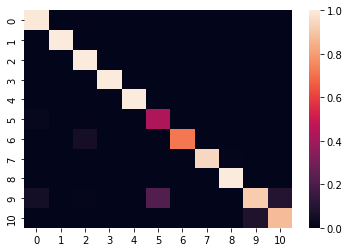

In [ ]:
M = exec_test(model,tokenizer,dataset['test'])
w = np.sum(M,axis=1)
for i in range(w.shape[0]):
    if w[i] == 0:
        w[i] = 1
sns.heatmap(M/w)



---


Let's compare without the weighting :

In [ ]:
exec_train(model,tokenizer,datasets.concatenate_datasets([dataset['train'],dataset['validation']]),False)

Training epoch 1: 100%|██████████| 663/663 [03:15<00:00,  3.39it/s, accuracy=0.939, loss=0.00628]


Test: 100%|██████████| 74/74 [00:06<00:00, 11.45it/s, accuracy=0.935]


test Acc: 0.9351969504447268


<Axes: >

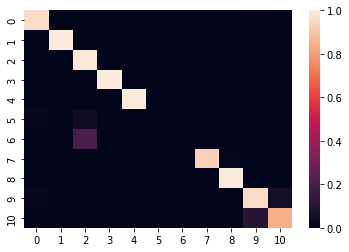

In [ ]:
M = exec_test(model,tokenizer,dataset['test'])
w = np.sum(M,axis=1)
for i in range(w.shape[0]):
    if w[i] == 0:
        w[i] = 1
sns.heatmap(M/w)

### Dataset `ilisten`

In [ ]:
#Load Dataset
miam= '/content/drive/MyDrive/ANLP/projet_anlp/miam.py'
dataset = datasets.load_dataset('miam','ilisten')

Generating train split:   0%|          | 0/1986 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/230 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/971 [00:00<?, ? examples/s]

Dataset miam downloaded and prepared to /root/.cache/huggingface/datasets/miam/ilisten/1.0.0/3cb25c5337f9e60db1dc6d90344763a6ef79d7a4ac3c5f215ce6e8afe99db26c. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
num_labels = len(set(dataset['train']['Label']))

In [ ]:
#Import model et tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', return_tensors='pt')
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased',num_labels=num_labels, problem_type="single_label_classification")


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

---


Let's run the training and test with weighting :

In [ ]:
exec_train(model,tokenizer,datasets.concatenate_datasets([dataset['train'],dataset['validation']]),True)

Map:   0%|          | 0/2216 [00:00<?, ? examples/s]

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


tensor([1.5694, 1.1515, 1.5211, 1.4302, 1.3847, 1.0631, 1.2911, 1.4651, 1.5383,
        1.0909, 1.0000, 1.7832, 1.4343, 1.0084, 1.7368], device='cuda:0')



Training epoch 1: 100%|██████████| 70/70 [00:20<00:00,  3.38it/s, accuracy=0.544, loss=0.0486]


Map:   0%|          | 0/971 [00:00<?, ? examples/s]


Test: 100%|██████████| 31/31 [00:02<00:00, 10.73it/s, accuracy=0.753]


test Acc: 0.752832131822863


<Axes: >

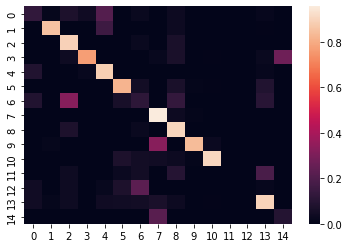

In [ ]:
M = exec_test(model,tokenizer,dataset['test'])
w = np.sum(M,axis=1)
for i in range(w.shape[0]):
    if w[i] == 0:
        w[i] = 1
sns.heatmap(M/w)


---


Let's compare without the weighting :

In [ ]:
exec_train(model,tokenizer,datasets.concatenate_datasets([dataset['train'],dataset['validation']]),False)


Training epoch 1: 100%|██████████| 70/70 [00:21<00:00,  3.31it/s, accuracy=0.783, loss=0.0217]



Test: 100%|██████████| 31/31 [00:02<00:00, 10.91it/s, accuracy=0.803]


test Acc: 0.8032955715756952


<Axes: >

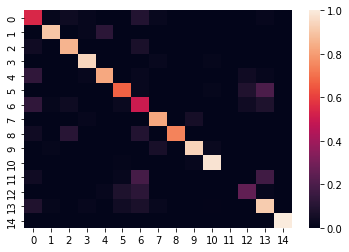

In [ ]:
M = exec_test(model,tokenizer,dataset['test'])
w = np.sum(M,axis=1)
for i in range(w.shape[0]):
    if w[i] == 0:
        w[i] = 1
sns.heatmap(M/w)

### Dataset `loria`

In [ ]:
#Load Dataset
miam= '/content/drive/MyDrive/ANLP/projet_anlp/miam.py'
dataset = datasets.load_dataset('miam','loria')

Generating train split:   0%|          | 0/8465 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/942 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1047 [00:00<?, ? examples/s]

Dataset miam downloaded and prepared to /root/.cache/huggingface/datasets/miam/loria/1.0.0/3cb25c5337f9e60db1dc6d90344763a6ef79d7a4ac3c5f215ce6e8afe99db26c. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
num_labels = len(set(dataset['train']['Label']))

In [ ]:
#Import model et tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', return_tensors='pt')
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased',num_labels=num_labels, problem_type="single_label_classification")


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

---


Let's run the training and test with weighting :

In [ ]:
exec_train(model,tokenizer,datasets.concatenate_datasets([dataset['train'],dataset['validation']]),True)

Map:   0%|          | 0/9407 [00:00<?, ? examples/s]

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


tensor([1.4448, 1.0092, 2.4286, 2.1224, 2.2651, 1.1122, 1.7250, 1.0000, 4.2448,
        2.1753, 2.5944, 2.7512, 2.9711, 2.2214, 2.2728, 4.6977, 2.1061, 1.6950,
        1.6241, 1.7153, 2.2214, 1.0976, 4.4428, 3.1821, 3.3218, 3.4987, 3.4345,
        3.3218, 3.0015, 2.5110, 1.3183], device='cuda:0')


Training epoch 1: 100%|██████████| 294/294 [01:26<00:00,  3.39it/s, accuracy=0.709, loss=0.0439]


Map:   0%|          | 0/1047 [00:00<?, ? examples/s]

Test: 100%|██████████| 33/33 [00:02<00:00, 11.32it/s, accuracy=0.835]


test Acc: 0.8347659980897804


<Axes: >

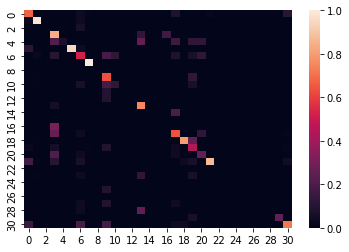

In [ ]:
M = exec_test(model,tokenizer,dataset['test'])
w = np.sum(M,axis=1)
for i in range(w.shape[0]):
    if w[i] == 0:
        w[i] = 1
sns.heatmap(M/w)

---


Let's compare without the weighting :

In [ ]:
exec_train(model,tokenizer,datasets.concatenate_datasets([dataset['train'],dataset['validation']]),False)

Training epoch 1: 100%|██████████| 294/294 [01:27<00:00,  3.36it/s, accuracy=0.816, loss=0.0204]


Test: 100%|██████████| 33/33 [00:02<00:00, 11.39it/s, accuracy=0.845]


test Acc: 0.8452722063037249


<Axes: >

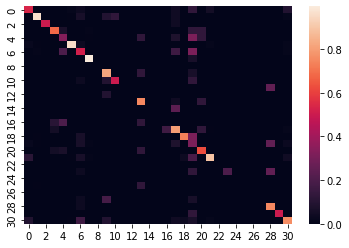

In [ ]:
M = exec_test(model,tokenizer,dataset['test'])
w = np.sum(M,axis=1)
for i in range(w.shape[0]):
    if w[i] == 0:
        w[i] = 1
sns.heatmap(M/w)

### Dataset `maptask`

In [ ]:
#Load Dataset
miam= '/content/drive/MyDrive/ANLP/projet_anlp/miam.py'
dataset = datasets.load_dataset('miam','maptask')

Generating train split:   0%|          | 0/25382 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5221 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5335 [00:00<?, ? examples/s]

Dataset miam downloaded and prepared to /root/.cache/huggingface/datasets/miam/maptask/1.0.0/3cb25c5337f9e60db1dc6d90344763a6ef79d7a4ac3c5f215ce6e8afe99db26c. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
num_labels = len(set(dataset['train']['Label']))

In [ ]:
#Import model et tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', return_tensors='pt')
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased',num_labels=num_labels, problem_type="single_label_classification")


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

---


Let's run the training and test with weighting :

In [ ]:
exec_train(model,tokenizer,datasets.concatenate_datasets([dataset['train'],dataset['validation']]),True)

Map:   0%|          | 0/30603 [00:00<?, ? examples/s]

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


tensor([1.0000, 1.3199, 1.2670, 1.4787, 1.2596, 1.0711, 1.6285, 1.3283, 1.2698,
        1.5738, 1.5614, 1.1391], device='cuda:0')


Training epoch 1: 100%|██████████| 957/957 [04:40<00:00,  3.41it/s, accuracy=0.555, loss=0.0426]


Map:   0%|          | 0/5335 [00:00<?, ? examples/s]

Test: 100%|██████████| 167/167 [00:14<00:00, 11.40it/s, accuracy=0.601]


test Acc: 0.6005623242736645


<Axes: >

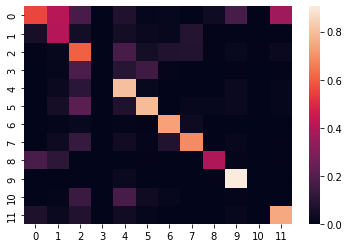

In [ ]:
M = exec_test(model,tokenizer,dataset['test'])
w = np.sum(M,axis=1)
for i in range(w.shape[0]):
    if w[i] == 0:
        w[i] = 1
sns.heatmap(M/w)

---


Let's compare without the weighting :

In [ ]:
exec_train(model,tokenizer,datasets.concatenate_datasets([dataset['train'],dataset['validation']]),False)

Training epoch 1: 100%|██████████| 957/957 [04:40<00:00,  3.41it/s, accuracy=0.602, loss=0.0368]


Test: 100%|██████████| 167/167 [00:14<00:00, 11.42it/s, accuracy=0.613]


test Acc: 0.612933458294283


<Axes: >

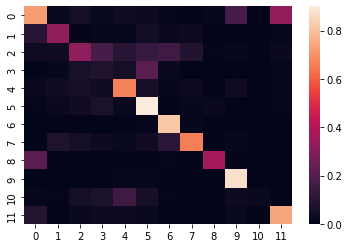

In [ ]:
M = exec_test(model,tokenizer,dataset['test'])
w = np.sum(M,axis=1)
for i in range(w.shape[0]):
    if w[i] == 0:
        w[i] = 1
sns.heatmap(M/w)

### Dataset `vm2`

In [ ]:
#Load Dataset
miam= '/content/drive/MyDrive/ANLP/projet_anlp/miam.py'
dataset = datasets.load_dataset('miam','vm2')

Generating train split:   0%|          | 0/25060 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2860 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2855 [00:00<?, ? examples/s]

Dataset miam downloaded and prepared to /root/.cache/huggingface/datasets/miam/vm2/1.0.0/3cb25c5337f9e60db1dc6d90344763a6ef79d7a4ac3c5f215ce6e8afe99db26c. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
num_labels = len(set(dataset['train']['Label']))

In [ ]:
#Import model et tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', return_tensors='pt')
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased',num_labels=num_labels, problem_type="single_label_classification")


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

---


Let's run the training and test with weighting :

In [ ]:
exec_train(model,tokenizer,datasets.concatenate_datasets([dataset['train'],dataset['validation']]),True)

Map:   0%|          | 0/27920 [00:00<?, ? examples/s]

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


tensor([1.1076, 1.2211, 1.8017, 1.9157, 1.7947, 1.7888, 1.9383, 2.0333, 1.5246,
        2.8136, 1.8866, 2.4202, 2.2863, 2.0259, 1.0769, 1.6281, 2.5805, 1.0000,
        1.4508, 2.6316, 1.4840, 2.9274, 2.2391, 2.0064, 1.6468, 1.9456, 1.5827,
        2.5017, 1.6379, 1.0325, 2.2017], device='cuda:0')


Training epoch 1: 100%|██████████| 873/873 [04:16<00:00,  3.41it/s, accuracy=0.576, loss=0.048]


Map:   0%|          | 0/2855 [00:00<?, ? examples/s]

Test: 100%|██████████| 90/90 [00:07<00:00, 11.28it/s, accuracy=0.549]


test Acc: 0.5485113835376533


<Axes: >

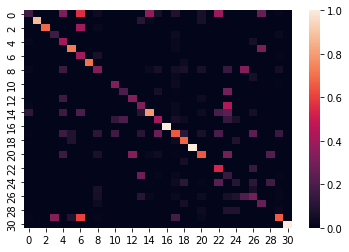

In [ ]:
M = exec_test(model,tokenizer,dataset['test'])
w = np.sum(M,axis=1)
for i in range(w.shape[0]):
    if w[i] == 0:
        w[i] = 1
sns.heatmap(M/w)

---


Let's compare without the weighting :

In [ ]:
exec_train(model,tokenizer,datasets.concatenate_datasets([dataset['train'],dataset['validation']]),False)

Training epoch 1: 100%|██████████| 873/873 [04:16<00:00,  3.40it/s, accuracy=0.767, loss=0.0218]


Test: 100%|██████████| 90/90 [00:08<00:00, 11.08it/s, accuracy=0.562]


test Acc: 0.5621716287215411


<Axes: >

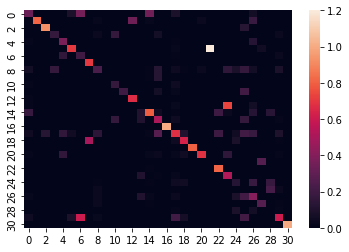

In [ ]:
M = exec_test(model,tokenizer,dataset['test'])
w = np.sum(M,axis=1)
for i in range(w.shape[0]):
    if w[i] == 0:
        w[i] = 1
sns.heatmap(M/w)

## Results

Here are the different results obtained for each dataset with the multilingual m-BERT model. We use here the metric `accuracy` (in %):


| Dataset name          | Language                                             | With weighting                |                         | Without weighting||
|--------------------------|----------------------------------------------------|--------------------------|--------------------------|-------------------------- | --------------------------|
|          |                                              | Train & Valid                 | Test                    |Train & Valid                 | Test                    |
|--------------------------|----------------------------------------------------|--------------------------|--------------------------|-------------------------- | --------------------------|
| dihana                   | Spanish                                           | 91.5                                   |94.7 |  93.9|93.5|   
| ilisten                  | Italian                                             | 54.4                     | 75.3                     |    78.3 |80.3|
| loria                    | French                                           | 70.9                             |83.5 |81.6|84.5                     |    
| maptask                  | English                                            | 55.5                            |60.1        |    60.2|       61.3|  
| vm2                      | German                                           | 57.6                           |54.9   |   76.7|56.2|
|--------------------------|----------------------------------------------------|--------------------------|--------------------------|--------------------------|--------------------------|
| **Total**                      |                                            | **66.0**                       |**73.7**   | **78.1**  | **75.2**|
      
   


We only make one `epoch` for training our model, which avoids overfitting. In this case the `valid set` is not needed and we group the `train` and `valid` sets for training.



---
If we compare our results to the m-BERT model from the [original paper](https://aclanthology.org/2021.emnlp-main.656.pdf), we find similar results, with an average of **73.7% accuracy** with weighting and **75.2% accuracy** with weighting for our model **vs.** **73.8%** for the original paper model